In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py

from akita_utils.utils import ut_dense

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_map_matrix(hf, num_sequences, head_index, model_index, num_background):
    """averaged over targets"""
    
    num_targets = 6
    if head_index != 1:
        num_targets = 5
    
    map_size = np.array(hf[f"e0_h{head_index}_m{model_index}_t0_b0"]).shape[0]
    
    map_matrix = np.zeros((map_size, map_size, num_sequences, num_background))

    for seq_index in range(num_sequences):
        for target_index in range(num_targets):
            for background_index in range(num_background):
                map_matrix[:, :, seq_index, background_index] += np.array(hf[f"e{seq_index}_h{head_index}_m{model_index}_t{target_index}_b{background_index}"])
    
    map_matrix = map_matrix / num_targets
    return map_matrix

def plot_map(matrix, vmin=-0.6, vmax=0.6, width=5, height=5, palette="RdBu_r"):

    """
    Plots a 512x512 map representating changes in the DNA contacts.

    Parameters
    ------------
    matrix : numpy array
        Changes in DNA contacts.
    vmin : float
    vmax : float
        Minimum and maximum in the colormap scale.
    width : int
    height : int
        Width and height of a plotted map.
    """

    fig = plt.figure(figsize=(width, height))

    sns.heatmap(
        matrix,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.show()
    

In [3]:
input_tsv_bg = "./../ctcf_tsv/all_motifs_boundary.tsv"
scores_tsv = "./../ctcf_tsv/filtered_base_mouse_ctcf_scores.tsv"

In [4]:
df = pd.read_table(input_tsv_bg, sep="\t")
df = df.drop(columns=["orientation", "flank_bp", "spacer_bp"])

In [5]:
scores_df = pd.read_table(scores_tsv, sep="\t")

In [6]:
def find_lower_boundary(request_exp_id, chunks_bounds):
    # finds the index of the biggest bound smaller than request_exp_id
    biggest_chunks_bound_index = 0
    for chunks_bound_index in range(len(chunks_bounds)):
        chunks_bound = chunks_bounds[chunks_bound_index]
        if chunks_bound < request_exp_id:
            biggest_chunks_bound_index = chunks_bound_index
        if chunks_bound > request_exp_id:
            return biggest_chunks_bound_index

def which_job(request_seq_id, request_bg_id, split_df, nr_sites, num_chunks):
    request_exp_id = request_bg_id * nr_sites + request_seq_id
    assert split_df.iloc[request_exp_id]["seq_id"] == request_seq_id

    # finding df boundaries
    df_len = len(df)
    chunks_bounds = np.linspace(0, df_len, num_chunks + 1, dtype="int")
    
    return find_lower_boundary(request_exp_id, chunks_bounds)

In [7]:
num_chunks = 20
nr_sites = len(scores_df)
model_index = 2

In [8]:
# background and target ids
request_bg_id = 3
request_tg_ids = [3]

# Restricting score

In [10]:
from random import sample

In [9]:
nr_maps = 15
# column_name = "boSCD_avg"
column_name = "cross_avg"
upperbound = 2.0
lowerbound = 1.0

In [11]:
restricted_seq_ids = list(scores_df[(scores_df[column_name] <= upperbound) & (scores_df[column_name] > lowerbound)].seq_id)

In [12]:
len(restricted_seq_ids)

12

In [13]:
if len(restricted_seq_ids) <= nr_maps:
    sample = restricted_seq_ids
else:
    sample = sample(restricted_seq_ids, nr_maps)
sample.sort()

In [14]:
sample_exp_id = [nr_sites * request_bg_id + seq_id for seq_id in sample]

In [15]:
# figuring out in which jobs are requested samples
job_list = []

for seq_id in sample:
    index = which_job(seq_id, request_bg_id, df, nr_sites, num_chunks)
    if index not in job_list:
        job_list.append(index)

In [16]:
job_list

[6, 7]

# Boundary maps

In [ ]:
for job_index in job_list:

    job_h5_file = f"/scratch2/smaruj/corrected_dots_vs_boundaries/boundaries_all_motifs_m{model_index}/job{job_index}/OUT.h5"
    job_h5_open = h5py.File(job_h5_file, "r")
    
    # append to final
    for key in job_h5_open.keys():
            
        if (key[0] == "e" and key != "end" and key !="exp_id"):
                
            identifiers = key.split("_")
            exp_id = int(identifiers[0][1:])
            seq_id = int(identifiers[1][1:])
            target_id = int(identifiers[4][1:])
            background_id = int(identifiers[5][1:])

            if exp_id in sample_exp_id and seq_id in sample and background_id == request_bg_id and target_id in request_tg_ids:

                print(f"exp_id: {exp_id}, seq_id: {seq_id}, target_id: {target_id}, background_id: {background_id}")
            
                map_matrix = np.array(job_h5_open[key])

                plot_map(map_matrix)
    
    job_h5_open.close()
    

# Dot maps

exp_id: 23629, seq_id: 1111, target_id: 3, background_id: 3


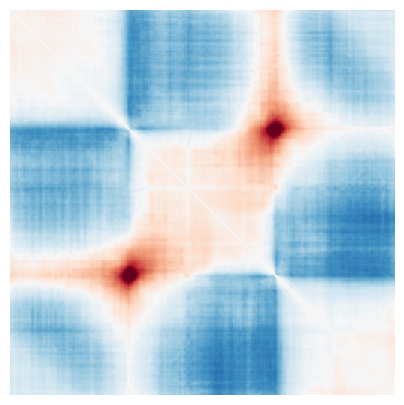

exp_id: 23698, seq_id: 1180, target_id: 3, background_id: 3


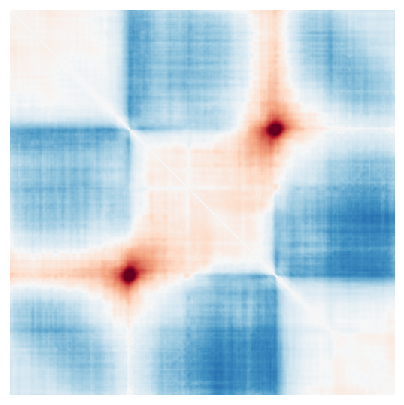

exp_id: 24231, seq_id: 1713, target_id: 3, background_id: 3


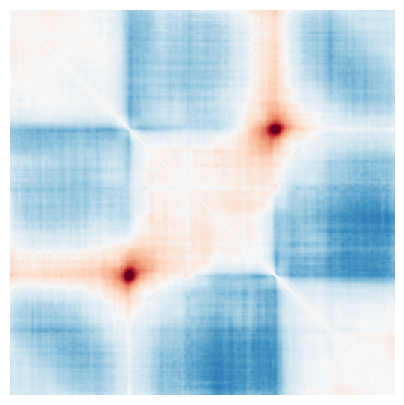

exp_id: 24536, seq_id: 2018, target_id: 3, background_id: 3


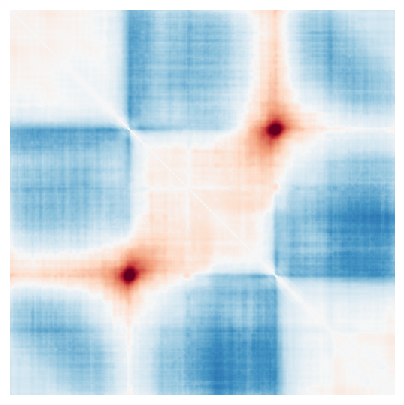

exp_id: 25451, seq_id: 2933, target_id: 3, background_id: 3


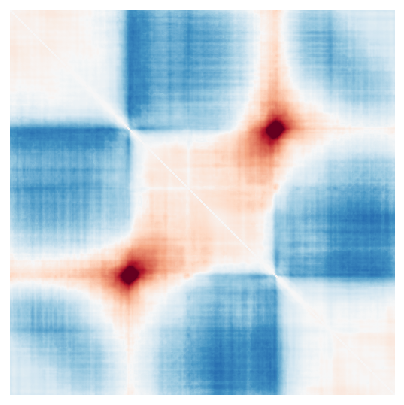

exp_id: 25539, seq_id: 3021, target_id: 3, background_id: 3


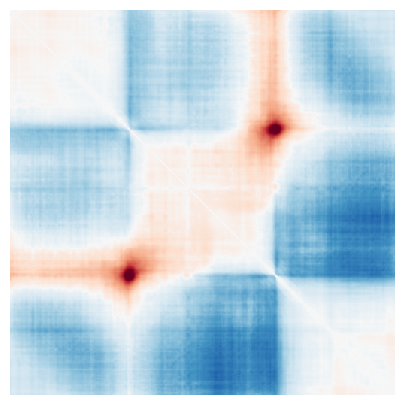

exp_id: 26187, seq_id: 3669, target_id: 3, background_id: 3


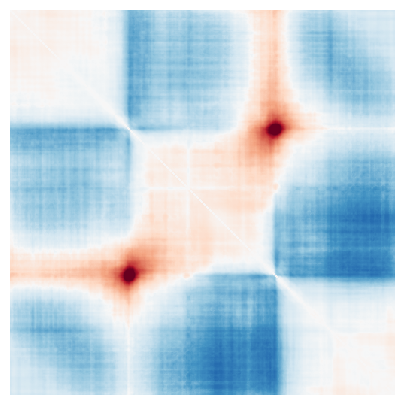

exp_id: 28136, seq_id: 5618, target_id: 3, background_id: 3


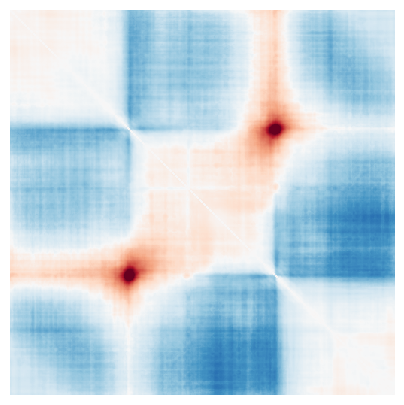

exp_id: 28305, seq_id: 5787, target_id: 3, background_id: 3


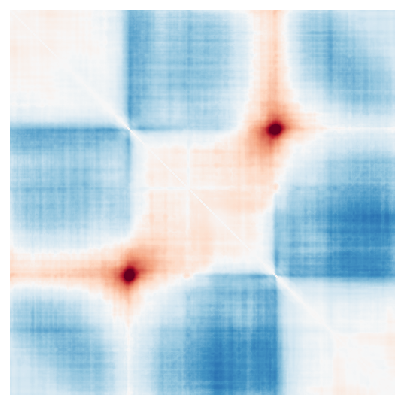

exp_id: 28311, seq_id: 5793, target_id: 3, background_id: 3


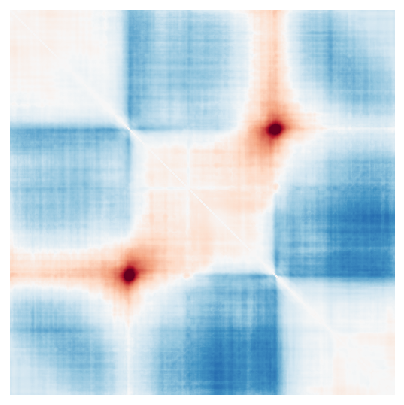

exp_id: 28567, seq_id: 6049, target_id: 3, background_id: 3


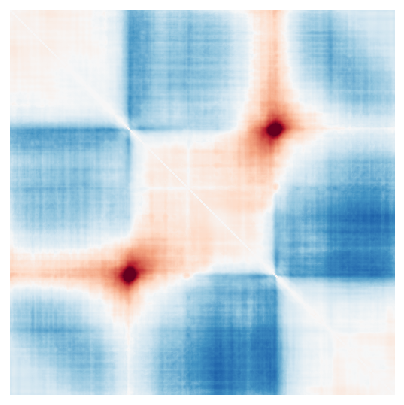

exp_id: 29174, seq_id: 6656, target_id: 3, background_id: 3


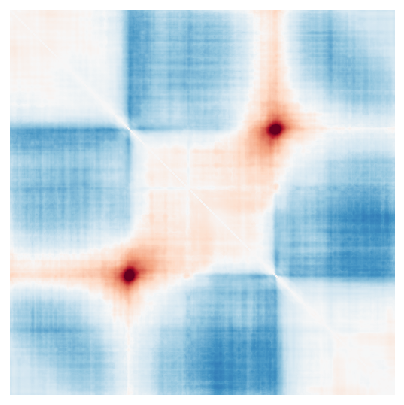

In [17]:
for job_index in job_list:

    job_h5_file = f"/scratch2/smaruj/corrected_dots_vs_boundaries/dots_all_motifs_m{model_index}/job{job_index}/OUT.h5"
    job_h5_open = h5py.File(job_h5_file, "r")
    
    # append to final
    for key in job_h5_open.keys():
            
        if (key[0] == "e" and key != "end" and key !="exp_id"):
                
            identifiers = key.split("_")
            exp_id = int(identifiers[0][1:])
            seq_id = int(identifiers[1][1:])
            target_id = int(identifiers[4][1:])
            background_id = int(identifiers[5][1:])

            if exp_id in sample_exp_id and seq_id in sample and background_id == request_bg_id and target_id in request_tg_ids:

                print(f"exp_id: {exp_id}, seq_id: {seq_id}, target_id: {target_id}, background_id: {background_id}")
            
                map_matrix = np.array(job_h5_open[key])

                plot_map(map_matrix)
    
    job_h5_open.close()